# Amazon Product Review NLP

##### This is an excerpt from my group project materials for Machine Learning and Statistical Data Analysis (COSC 274). The goal of the project was to train a classifier to successfully predict an Amazon product's rating as "awesome" or not (defined as >4.5 stars) based upon its reviews. Project collaborators include YB Choi, Ji-Qing Chen, and Shan-Chang Lin.

The project dataset is a collection of Toys and Games product reviews from Amazon and is not included in this repo because of its very large file size. You can retrieve this data from https://nijianmo.github.io/amazon/index.html

### Import Statements

In [18]:
import pandas as pd
import numpy as np
import nltk 
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import string
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

C:\Users\busch_000\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import metrics

In [3]:
nltk.download('words')
nltk.download('stopwords')
words = nltk.corpus.words.words()
sw = stopwords.words('english')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\busch_000\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\busch_000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Pre-Processing Review Text
First we clean the text of the reviews by removing stopwords, punctuation, words with numbers, and "stem" the words. We will train the classifier on both the cleaned and original review text for comparison later.

### Define functions for cleaning reviewtext

In [4]:
def remove_stopwords(text):
    # removes stop words and lowercases the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [5]:
def remove_punctuation(text):
    # replace punctuations with no space, 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [6]:
def remove_number_words(text):
    # remove words that also have numbers
    text = [word for word in text.split() if word.isalpha()]
    # joining the list of words with space separator
    return " ".join(text)

In [7]:
def stemming(text):    
    #stems the words in the text
    stemmer = SnowballStemmer("english")
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

### Load review data, clean the reviews, and save as .csv

In [20]:
path_to_datasets = '' #please insert the path_to_dataset here
#df = pd.read_json(path_to_datasets + 'Toys_and_Games_Ratings_training.json', lines=True)
dft = pd.read_json('Toys_and_Games_Reviews_training.json', lines=True)

In [21]:
#remove NaN's
clean_df = dft[dft['reviewText'].notna()]
df2 = clean_df[['asin', 'overall', 'reviewText', 'summary']]

In [26]:
#Group reviews by product

avg = df2[['asin', 'overall']].groupby('asin').mean()
# assian traget=1 if averaged overall>4.5 and target=0 otherwise
avg2 = avg.assign(
    Target = lambda dataframe: dataframe['overall'].map(lambda overall: "1" if overall >4.5 else "0") 
)
avg2 = avg2.rename_axis("asin").reset_index()
avg2.columns = ['asin','overall_avg', 'Target']

# select coloumns
df3 = df2[['asin', 'overall', 'reviewText', 'summary']]

dft4 = df3.groupby('asin')['reviewText'].apply(' '.join).reset_index()
# assign target to df2
dft = dft4.merge(avg2, on = 'asin', how ='left')
#add column for processed reviews
clean_text = dft['reviewText']
dft['CleanedText'] = clean_text

In [28]:
#apply each function for cleaning reviews
dft['CleanedText'] = dft['CleanedText'].progress_apply(remove_punctuation)

100%|█████████████████████████████████████████████████████████████████████████| 63017/63017 [00:03<00:00, 16343.80it/s]


In [29]:
dft['CleanedText'] = dft['CleanedText'].progress_apply(remove_stopwords)

100%|███████████████████████████████████████████████████████████████████████████| 63017/63017 [03:10<00:00, 330.31it/s]


In [30]:
dft['CleanedText'] = dft['CleanedText'].progress_apply(remove_number_words)

100%|██████████████████████████████████████████████████████████████████████████| 63017/63017 [00:11<00:00, 5719.90it/s]


In [31]:
dft['CleanedText'] = dft['CleanedText'].progress_apply(stemming)

100%|████████████████████████████████████████████████████████████████████████████| 63017/63017 [16:57<00:00, 61.95it/s]


In [32]:
dft.to_csv('dft.csv')

### Load cleaned data once reviews are cleaned

In [5]:
dft = pd.read_csv('dft.csv')
dft.head(10)

,Unnamed: 0,asin,reviewText,overall_avg,Target,CleanedText
0,0,000254CDA01E5AE839E7EE3F6FC1D2F1,The child who recieved them opened the box and...,4.625000,1,child reciev open box thrill assum big hit got...
1,1,0002E81AED1B9840434EE28E39876BE4,Great gift for my special needs cousin Blocks ...,2.538462,0,great gift special need cousin block hardley m...
2,2,0003806D9BE7957D8AB9AF9EC04F52D0,I needed something to occupy kids indoors that...,5.000000,1,need someth occupi kid indoor electron bought ...
3,3,00049B538C925B3EF702FFF6FBD48DFE,This is a very nicely detailed and painted die...,4.625000,1,nice detail paint die cast version slave prett...
4,4,0004D0377FDC88F2DD349170E36324E7,Cute This bear is so cool and cute. The fabric...,5.000000,1,cute bear cool cute fabric soft one ear fold m...
5,5,000564E0025921626AF9AD7CE58C4DE9,Bought this for my almost three year old grand...,4.777778,1,bought almost three year old grandson crosbi l...
6,6,0006001B48B2A068D15FA5DF6A8D8120,"Very fast and fun to watch, easy to use for a ...",4.400000,0,fast fun watch easi use littl one push button ...
7,7,00060723DBA4B273D9C4D8BBF00B472D,Bought for grandchildren for Christmas. They ...,4.923077,1,bought grandchildren christma seem like parent...
8,8,0006215CD3B7AB524822EA4B03BF1D35,This is a fun game that will help you practice...,4.200000,0,fun game help practic win lot ticket arcad how...
9,9,0008B770C9308FC846F8F87ED244A2D6,My 4-year-old son has a Miyim bear that he lov...,3.400000,0,son miyim bear love hes pooh chapter book thou...


In [6]:
#remove NaNs
dft = dft[dft['reviewText'].notna()] 

## Check for class imbalance and visualize most frequent words

check for class imbalance in target variable (whether product "awesome" or not)

In [35]:
# create a count vectorizer object
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize)
# fit the count vectorizer using the text data
text_counts = count_vectorizer.fit_transform(dft['CleanedText'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()  

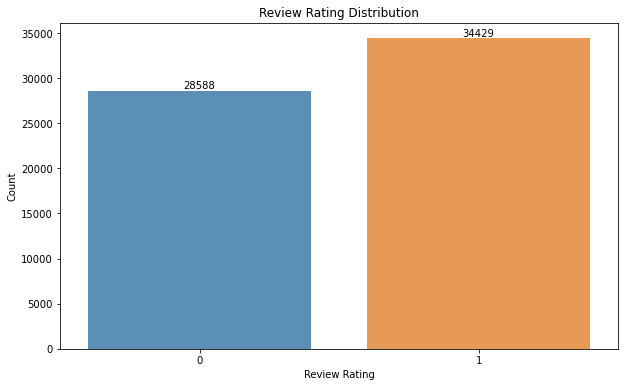

In [36]:
x=dft['Target'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Review Rating Distribution")
plt.ylabel('Count')
plt.xlabel('Review Rating')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

notice how there are slightly more "awesome" products by rating than there are "not awesome" products

visualize the most frequent stemmed words in the cleaned reviews

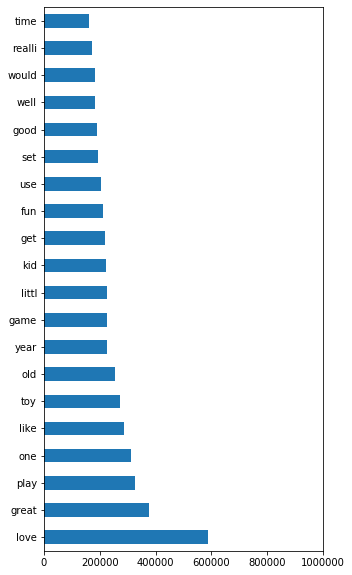

In [30]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
freq= pd.Series((' '.join(dft['CleanedText']).split())).value_counts().sort_values(ascending = False)
top_vacab = freq.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10),xlim= (0,1000000))

## Feature generation based on product reviews

### Bag of Words feature generation

The Bag of Words (BoW) model treats a sentence or document (in this case the aggregated reviews for each product) as a "bag" and each unique word in the document or sentence is added to the bag. The unique words are then counted for each bag. 

In [11]:
##for original review text
# create a count vectorizer object
token = RegexpTokenizer(r'[a-zA-Z]+')
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

# fit the count vectorizer using the text data
text_counts = count_vectorizer.fit_transform(dft['reviewText'])

# words appear in documents.
tokens = count_vectorizer.get_feature_names()
#print(tokens)

##repeat for cleaned review text
# fit the count vectorizer using the text data
text_counts_cleaned = count_vectorizer.fit_transform(dft['CleanedText'])

# words appear in documents.
tokens_cleaned = count_vectorizer.get_feature_names()
#print(tokens)

In [12]:
# split traning data and testing data for text counts from original reviews
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, dft['Target'], test_size=0.2, random_state=1)

# split traning data and testing data for text counts from cleaned reviews
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    text_counts_cleaned, dft['Target'], test_size=0.2, random_state=1)

### TF-IDF feature generation

TF-IDF stands for term frequency inverse document frequency and is a statistical measure of how relavent a word is to a document in a corpus of documents (in this case aggregated reviews for all products in the dataset). The term frequency (TF) term captures the relative importance of terms to a document and the inverse document frequency (IDF) captures the relative rarity of a term in a document.

In [13]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(dft['reviewText'])
text_tf_cleaned= tf.fit_transform(dft['CleanedText'])

In [14]:
# split traning data and testing data for text counts from original reviews
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    text_tf, dft['Target'], test_size=0.2, random_state=1)

# split traning data and testing data for text counts from cleaned reviews
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    text_tf_cleaned, dft['Target'], test_size=0.2, random_state=1)

## Training Classifiers

each set of training data created above (for each feature I generated) is trained on three different classifiers: Multinomial Naive Bayes, Logistic Regression with a linear kernel, and a Random Forest.

### Multinomial NB

In [28]:
clf_bow = MultinomialNB().fit(X_train, y_train)
clf_clean_bow = MultinomialNB().fit(X_train2, y_train2)
clf_tfidf = MultinomialNB().fit(X_train3, y_train3)
clf_clean_tfidf = MultinomialNB().fit(X_train4, y_train4)

probas1= clf_bow.predict_proba(X_test)
probas2= clf_clean_bow.predict_proba(X_test2)
probas3= clf_tfidf.predict_proba(X_test3)
probas4= clf_clean_tfidf.predict_proba(X_test4)

score = cross_val_score(clf_bow, X_train, y_train, cv=10, scoring='f1')
print("F1-score BoW original reviews: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score2 = cross_val_score(clf_clean_bow, X_train2, y_train2, cv=10, scoring='f1')
print("F1-score BoW cleaned reviews: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))
score3 = cross_val_score(clf_tfidf, X_train3, y_train3, cv=10, scoring='f1')
print("F1-score TFIDF original reviews: %0.2f (+/- %0.2f)" % (score3.mean(), score3.std() * 2))
score4 = cross_val_score(clf_clean_tfidf, X_train4, y_train4, cv=10, scoring='f1')
print("F1-score TFIDF cleaned reviews: %0.2f (+/- %0.2f)" % (score4.mean(), score4.std() * 2))

F1-score BoW original reviews: 0.76 (+/- 0.01)
F1-score BoW cleaned reviews: 0.76 (+/- 0.01)
F1-score TFIDF original reviews: 0.76 (+/- 0.01)
F1-score TFIDF cleaned reviews: 0.76 (+/- 0.01)


### Logistic Regression

In [29]:
#Create a Classifier
clf2_bow = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train, y_train)
clf2_clean_bow = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train2, y_train2)
clf2_tfidf = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train3, y_train3)
clf2_clean_tfidf = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train4, y_train4)

probas9= clf2_bow.predict_proba(X_test)
probas10= clf2_clean_bow.predict_proba(X_test2)
probas11= clf2_tfidf.predict_proba(X_test3)
probas12= clf2_clean_tfidf.predict_proba(X_test4)

score = cross_val_score(clf2_bow, X_train, y_train, cv=10, scoring='f1')
print("F1-score BoW original reviews: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score2 = cross_val_score(clf2_clean_bow, X_train2, y_train2, cv=10, scoring='f1')
print("F1-score BoW cleaned reviews: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))
score3 = cross_val_score(clf2_tfidf, X_train3, y_train3, cv=10, scoring='f1')
print("F1-score TFIDF original reviews: %0.2f (+/- %0.2f)" % (score3.mean(), score3.std() * 2))
score4 = cross_val_score(clf2_clean_tfidf, X_train4, y_train4, cv=10, scoring='f1')
print("F1-score TFIDF cleaned reviews: %0.2f (+/- %0.2f)" % (score4.mean(), score4.std() * 2))

F1-score BoW original reviews: 0.80 (+/- 0.02)
F1-score BoW cleaned reviews: 0.80 (+/- 0.01)
F1-score TFIDF original reviews: 0.83 (+/- 0.01)
F1-score TFIDF cleaned reviews: 0.83 (+/- 0.01)


### Random Forest

In [27]:
clf3_bow = RandomForestClassifier(n_estimators=50, random_state=1).fit(X_train, y_train)
clf3_clean_bow = RandomForestClassifier(n_estimators=50, random_state=1).fit(X_train2, y_train2)
clf3_tfidf = RandomForestClassifier(n_estimators=50, random_state=1).fit(X_train3, y_train3)
clf3_clean_tfidf = RandomForestClassifier(n_estimators=50, random_state=1).fit(X_train4, y_train4)

probas5= clf3_bow.predict_proba(X_test)
probas6= clf3_clean_bow.predict_proba(X_test2)
probas7= clf3_tfidf.predict_proba(X_test3)
probas8= clf3_clean_tfidf.predict_proba(X_test4)

score = cross_val_score(clf3_bow, X_train, y_train, cv=10, scoring='f1')
print("F1-score BoW original reviews: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score2 = cross_val_score(clf3_clean_bow, X_train2, y_train2, cv=10, scoring='f1')
print("F1-score BoW cleaned reviews: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))
score3 = cross_val_score(clf3_tfidf, X_train3, y_train3, cv=10, scoring='f1')
print("F1-score TFIDF original reviews: %0.2f (+/- %0.2f)" % (score3.mean(), score3.std() * 2))
score4 = cross_val_score(clf3_clean_tfidf, X_train4, y_train4, cv=10, scoring='f1')
print("F1-score TFIDF cleaned reviews: %0.2f (+/- %0.2f)" % (score4.mean(), score4.std() * 2))

F1-score: 0.77 (+/- 0.01)
F1-score: 0.77 (+/- 0.01)
F1-score: 0.77 (+/- 0.01)
F1-score: 0.77 (+/- 0.01)


## Comparing classifier-feature combinations

### ROC Curve for Comparison of Classifier-Feature Pairs

The ROC curve plots the True Positive Rate on the y-axis and the False Positive Rate on the x-axis and is a visual way to compare the performance of different classifiers against one another. The more concave each ROC curve is towards the upper-left hand corner of the plot, the better the classifier performance.

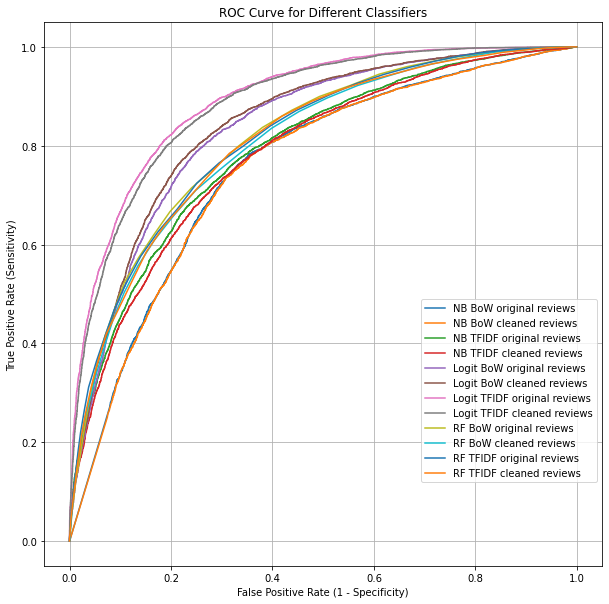

In [30]:
f = plt.figure(figsize=[10,10]) 
plt.plot(roc_curve(y_test, probas1[:,1])[0], roc_curve(y_test, probas1[:,1])[1], label = 'NB BoW original reviews')
plt.plot(roc_curve(y_test2, probas2[:,1])[0], roc_curve(y_test2, probas2[:,1])[1], label = 'NB BoW cleaned reviews')
plt.plot(roc_curve(y_test3, probas3[:,1])[0], roc_curve(y_test3, probas3[:,1])[1], label = 'NB TFIDF original reviews')
plt.plot(roc_curve(y_test4, probas4[:,1])[0], roc_curve(y_test4, probas4[:,1])[1], label = 'NB TFIDF cleaned reviews')

plt.plot(roc_curve(y_test, probas9[:,1])[0], roc_curve(y_test, probas9[:,1])[1], label = 'Logit BoW original reviews')
plt.plot(roc_curve(y_test2, probas10[:,1])[0], roc_curve(y_test2, probas10[:,1])[1], label = 'Logit BoW cleaned reviews')
plt.plot(roc_curve(y_test3, probas11[:,1])[0], roc_curve(y_test3, probas11[:,1])[1], label = 'Logit TFIDF original reviews')
plt.plot(roc_curve(y_test4, probas12[:,1])[0], roc_curve(y_test4, probas12[:,1])[1], label = 'Logit TFIDF cleaned reviews')

plt.plot(roc_curve(y_test, probas5[:,1])[0], roc_curve(y_test, probas5[:,1])[1], label = 'RF BoW original reviews')
plt.plot(roc_curve(y_test2, probas6[:,1])[0], roc_curve(y_test2, probas6[:,1])[1], label = 'RF BoW cleaned reviews')
plt.plot(roc_curve(y_test3, probas7[:,1])[0], roc_curve(y_test3, probas7[:,1])[1], label = 'RF TFIDF original reviews')
plt.plot(roc_curve(y_test4, probas8[:,1])[0], roc_curve(y_test4, probas8[:,1])[1], label = 'RF TFIDF cleaned reviews')

plt.title('ROC Curve for Different Classifiers')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.legend(bbox_to_anchor=(1.0, .5))

plt.show()



the best performer is the TFIDF feature for the original (uncleaned) product reviews with the logistic regression classifier- 83% F1-score with 10-fold CV isn't bad!

it's interesting that cleaning the reviews did not help classifier performance in any of the feature-classifier pairs...

### Confusion Matrix for Best Model Prediction (TFIDF - Logistic Regression with original reviews)

Resource: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [31]:
clf2_tfidf = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train3, y_train3)
predict = clf2_tfidf.predict(X_test3)

from sklearn.metrics import classification_report
print(classification_report(y_test3,predict))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      5774
           1       0.82      0.84      0.83      6830

    accuracy                           0.81     12604
   macro avg       0.81      0.81      0.81     12604
weighted avg       0.81      0.81      0.81     12604



Confusion matrix, without normalization
[[4490 1284]
 [1060 5770]]
Normalized confusion matrix
[[0.77762383 0.22237617]
 [0.15519766 0.84480234]]


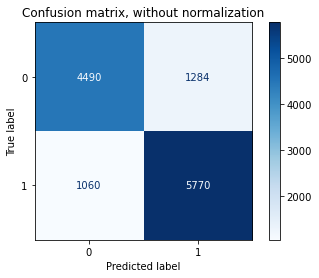

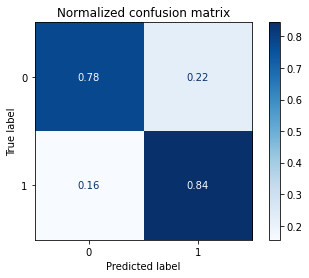

In [33]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf2_tfidf, X_test3, y_test3,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Notice how the classifier predicts slightly better for "awesome" products (label=1) vs. "not awesome" products (label=0). This might have to do with the slight class imbalance seen from above